In [129]:
#Import libraries
from sqlalchemy import create_engine
import pandas as pd
from sqlalchemy import inspect
from datetime import datetime as dt
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport


# EDA steps:
## 1- Sourcing Data

In [130]:
engine = create_engine("sqlite:///sqlite/MTA_1.db")
all_tables = inspect(engine)


mta = pd.read_sql('SELECT * FROM mta;', engine)
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISON,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,00:00:00,REGULAR,7578734,2590325
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,04:00:00,REGULAR,7578740,2590327
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,08:00:00,REGULAR,7578749,2590340
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,12:00:00,REGULAR,7578789,2590386
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,16:00:00,REGULAR,7578897,2590418


# 2- Cleaning Data

In [131]:
#Check For Missing Data
mta.isnull().sum()


C/A         0
UNIT        0
SCP         0
STATION     0
LINENAME    0
DIVISON     0
DATE        0
TIME        0
DESC        0
ENTRIES     0
EXITS       0
dtype: int64

In [132]:
# combining Date & time columns 

mta['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)
mta.sort_values(by=['datetime'], inplace=True)

In [133]:
#convert ENTRIES and EXITS to number of entries and number of exits 

mta['n_ent'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta['n_ext'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

In [134]:
# get total turnstile traffic out of entries and exits

mta['turn_traffic'] = mta.n_ent + mta.n_ext
mta.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISON,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_ent,n_ext,turn_traffic
2633939,PTH04,R551,00-01-04,GROVE STREET,1,PTH,08/27/2021,23:57:09,REGULAR,14168,92933,2021-08-27 23:57:09,28.0,355.0,383.0
2637446,PTH12,R542,00-04-02,TWENTY THIRD ST,1,PTH,08/27/2021,23:57:50,REGULAR,31262,891186,2021-08-27 23:57:50,1.0,74.0,75.0
2639243,PTH17,R541,01-00-02,THIRTY THIRD ST,1,PTH,08/27/2021,23:59:08,REGULAR,1,98219,2021-08-27 23:59:08,0.0,92.0,92.0
2636132,PTH07,R550,00-01-08,CITY / BUS,1,PTH,08/27/2021,23:59:43,REGULAR,40889,124878,2021-08-27 23:59:43,9.0,54.0,63.0
2634218,PTH04,R551,00-04-05,GROVE STREET,1,PTH,08/27/2021,23:59:56,REGULAR,312741,159053,2021-08-27 23:59:56,8.0,29.0,37.0


In [135]:

mask = (mta.n_ent >= 0) & (mta.n_ext >= 0) & (mta.turn_traffic >= 0) & (mta.turn_traffic < 3000)
mta = mta[mask]


In [136]:
#Add week days column to the dataframe

mta['day_of_week'] = mta['datetime'].apply(lambda x : x.weekday())
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISON,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_ent,n_ext,turn_traffic,day_of_week
73983,N192,R336,00-05-00,BEACH 60 ST,A,IND,05/29/2021,04:00:00,REGULAR,117440944,0,2021-05-29 04:00:00,0.0,0.0,0.0,5
34240,H010,R235,01-00-01,BEDFORD AV,L,BMT,05/29/2021,04:00:00,REGULAR,1199558,2770525,2021-05-29 04:00:00,16.0,35.0,51.0,5
74067,N193,R337,00-00-00,BEACH 44 ST,A,IND,05/29/2021,04:00:00,REGULAR,53119,137434,2021-05-29 04:00:00,1.0,14.0,15.0,5
74109,N193,R337,00-00-01,BEACH 44 ST,A,IND,05/29/2021,04:00:00,REGULAR,1193328,1494139,2021-05-29 04:00:00,2.0,11.0,13.0,5
73941,N192,R336,00-00-02,BEACH 60 ST,A,IND,05/29/2021,04:00:00,REGULAR,45077,26127,2021-05-29 04:00:00,9.0,7.0,16.0,5


In [137]:
#group stations by turnstile traffics 

stations_totals = mta.groupby('STATION', as_index=False).turn_traffic.sum()
stations_totals.sort_values(by='turn_traffic', ascending=False, inplace=True)
stations_totals.head(10)

,STATION,turn_traffic
61,34 ST-PENN STA,9230504.0
59,34 ST-HERALD SQ,6931015.0
233,GRD CNTRL-42 ST,6827385.0
110,86 ST,6168750.0
14,14 ST-UNION SQ,5948788.0
46,23 ST,5529847.0
68,42 ST-PORT AUTH,5457160.0
9,125 ST,5364979.0
353,TIMES SQ-42 ST,5227830.0
226,FULTON ST,4819739.0


## 3- Visualizations

### 3.1 Top 10 Busiest stations

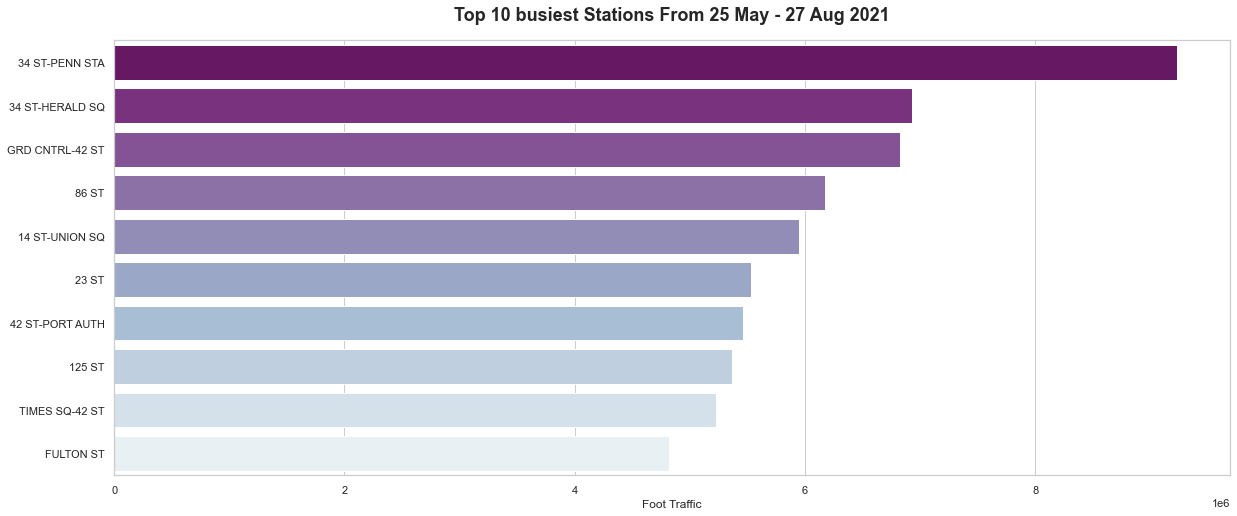

<Figure size 432x288 with 0 Axes>

In [138]:
# plot top 10 stations in terms of traffic 
from importlib import reload
reload(plt)

plt.figure(figsize=[20,8])
sns.set(style="whitegrid")
sns.barplot(x='turn_traffic', y='STATION', data=stations_totals.head(10),palette="BuPu_r", orient="h");

plt.title('Top 10 busiest Stations From 25 May - 27 Aug 2021',weight = 'bold', pad='20', size=18)
plt.xlabel('Foot Traffic')
plt.ylabel('')
plt.show()

plt.savefig('Top 10 Busiest sts.png')

### 3.2 plotting for each month alone to compare between them


In [139]:

#filter on June data
mta_june =mta[(mta.DATE <= '06/30/2021')]
